Nama Anggota Kelompok : 
  1. Ahmad Junjung S. -  201910370311405
  2. Lidya Fankky O.P -  201910370311448

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import zipfile

In [8]:
# Definisikan path kaggle json
# Sesuaikan dengan path anda
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/TKC /Tugas 1"

In [9]:
# Ubah lokasi direktori kerja
# Sesuaikan dengan path anda
%cd /content/drive/MyDrive/TKC /Tugas 1
!ls -a

/content/drive/MyDrive/TKC /Tugas 1
kaggle.json  Untitled0.ipynb


In [10]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:15<00:00, 159MB/s]
100% 2.29G/2.29G [00:15<00:00, 154MB/s]


In [15]:
# Ekstrak dataset
local_zip = "/content/drive/MyDrive/TKC /Tugas 1/chest-xray-pneumonia.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/TKC /Tugas 1/chest_xray_dataset/')
zip_ref.close()

In [19]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.8.2


In [26]:
# Import the required modules
from skimage import img_as_float
from skimage import exposure
import plotly.graph_objects as go

import os
import glob
import random
from skimage import io # To preprocess the images
from distutils.file_util import copy_file
import seaborn as sns
import cv2
import keras
from keras.models import load_model
from keras import backend as K
import tensorflow as tf

from skimage.transform import rescale
from keras_preprocessing.image import ImageDataGenerator

import warnings
warnings.simplefilter('ignore')

In [33]:
base_dir = '/content/drive/MyDrive/TKC /Tugas 1/chest_xray_dataset/chest_xray/train'
cls = ['NORMAL', 'PNEUMONIA']

In [38]:
base_dir = '/content/drive/MyDrive/TKC /Tugas 1/chest_xray_dataset/chest_xray'

train_dir = os.path.join(base_dir, 'train')
norm_train_dir = os.path.join(train_dir, 'NORMAL')
pneu_train_dir = os.path.join(train_dir, 'PNEUMONIA')

val_dir = os.path.join(base_dir, 'test')
norm_val_dir = os.path.join(val_dir, 'NORMAL')
pneu_val_dir = os.path.join(val_dir, 'PNEUMONIA')

In [39]:
print("Total Training NORMAL:", len(os.listdir(norm_train_dir)))
print("Total Training PNEUMONIA:", len(os.listdir(pneu_train_dir)))
print()
print("Total validation NORMAL:", len(os.listdir(norm_val_dir)))
print("Total validation PNEUMONIA:", len(os.listdir(pneu_val_dir)))

Total Training NORMAL: 1341
Total Training PNEUMONIA: 3875

Total validation NORMAL: 234
Total validation PNEUMONIA: 390


In [50]:
def gather_data(data_dir):
    dir_data = []
    dir_label = []

    for dirpath, dirnames, filenames in os.walk(data_dir):
        for file in filenames:
            if ".jpeg" in file:
                image_path = os.path.join(dirpath, file)

                image = cv2.imread(image_path)
                image = cv2.resize(image, (150,150))
                image = image.astype('float32') / 255.0
                dir_data.append(image)

                label = int((image_path.split(os.path.sep)[-2]) == 'PNEUMONIA')
                dir_label.append(label)

    dir_data = np.array(dir_data)
    dir_label = np.array(dir_label)

    return dir_data, dir_label

In [51]:
x_train, y_train = gather_data(train_dir)
x_val, y_val = gather_data(val_dir)

In [58]:
gather_save = '/content/drive/MyDrive/TKC /Tugas 1'

In [61]:
preprocessed_data = [x_train, y_train, x_val, y_val]
preprocessed_file_name = ['x_train', 'y_train', 'x_val', 'y_val']
for i, file_name in enumerate(preprocessed_file_name):
    np.save(gather_save + '/' + file_name + '.npy', preprocessed_data[i])

In [62]:
import numpy as np

In [63]:
x_train = np.load(gather_save + '/x_train.npy')
y_train = np.load(gather_save + '/y_train.npy')

x_val = np.load(gather_save + '/x_val.npy')
y_val = np.load(gather_save + '/y_val.npy')

In [64]:
print("Train Data = ", x_train.shape)
print("Train Label = ", y_train.shape)
print()
print("Val Data = ", x_val.shape)
print("Val Label = ", y_val.shape)

Train Data =  (5216, 150, 150, 3)
Train Label =  (5216,)

Val Data =  (624, 150, 150, 3)
Val Label =  (624,)


In [65]:
from skimage.io import imread
from skimage.transform import resize

In [66]:
def conv_block(filters):
    block = Sequential([
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        SeparableConv2D(filters, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D()
    ])
    
    return block

In [67]:
def dense_block(units, dropout_rate):
    block = Sequential([
        Dense(units, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate)
    ])
    
    return block

In [68]:
def build_model():
    model = Sequential([
        Input(shape=(150, 150, 3)),

        Conv2D(16, 3, activation='relu', padding='same'),
        Conv2D(16, 3, activation='relu', padding='same'),
        MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        conv_block(128),
        
        Dropout(0.2),
        
        conv_block(256),
        
        Dropout(0.2),
        Flatten(),
        
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        Dense(1, activation='sigmoid')
    ])
    
    return model

In [73]:
base_dir = '/content/drive/MyDrive/TKC /Tugas 1/chest_xray_dataset/chest_xray/train/'

In [74]:
norm_dir = os.path.join(base_dir, 'NORMAL')
pneu_dir = os.path.join(base_dir, 'PNEUMONIA')

print("Total Training NORMAL:", len(os.listdir(norm_dir)))
print("Total Training PNEUMONIA:", len(os.listdir(pneu_dir)))

Total Training NORMAL: 1341
Total Training PNEUMONIA: 3875


In [75]:
norm_data_count = len(os.listdir(norm_dir))
pneu_data_count = len(os.listdir(pneu_dir))

print(f"Jumlah Normal: {norm_data_count}\nJumlah Pneoumonia: {pneu_data_count}")

Jumlah Normal: 1341
Jumlah Pneoumonia: 3875


In [77]:
weight_for_0 = (1 / norm_data_count) * (x_train.shape[0]) / 2.0 
weight_for_1 = (1 / pneu_data_count) * (x_train.shape[0]) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.94
Weight for class 1: 0.67


In [78]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, InputLayer, MaxPool2D, SeparableConv2D
from tensorflow.keras.metrics import Precision, Recall

In [79]:
model = build_model()

METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
]
    
model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
)

In [80]:
BATCH_SIZE = 128
EPOCH = 25

In [81]:
BATCH_SIZE = 128
EPOCH = 25

In [83]:
TRAIN_IMG_COUNT = x_train.shape[0]
VAL_IMG_COUNT = x_val.shape[0]

In [84]:
history = model.fit(x_train, y_train,
              steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
              epochs=EPOCH,
              validation_data=(x_val, y_val),
              validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
              class_weight=class_weight,
              )

Epoch 1/25
40/40 [==============================] - 33s 376ms/step - loss: 0.4826 - accuracy: 0.7276 - precision: 0.9404 - recall: 0.6761 - val_loss: 0.6732 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 2/25
40/40 [==============================] - 12s 296ms/step - loss: 0.2149 - accuracy: 0.9135 - precision: 0.9825 - recall: 0.8996 - val_loss: 0.7496 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 3/25
40/40 [==============================] - 12s 298ms/step - loss: 0.1639 - accuracy: 0.9398 - precision: 0.9837 - recall: 0.9345 - val_loss: 1.0063 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 4/25
40/40 [==============================] - 12s 300ms/step - loss: 0.1267 - accuracy: 0.9546 - precision: 0.9845 - recall: 0.9538 - val_loss: 1.2167 - val_accuracy: 0.6250 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 5/25
40/40 [==============================] - 12s 305ms/step - loss: 0.1065 - accuracy: 0.9640

In [85]:
import json
target_dir = '/content/drive/MyDrive/TKC /Tugas 1'

In [86]:
history_dict = history.history
json.dump(history_dict, open(target_dir + '/train_model_history_ke1.json', 'w'))

model.save(target_dir + '/train_model_ke1.h5')
model.save_weights(target_dir + '/train_model_weights_ke1.h5')

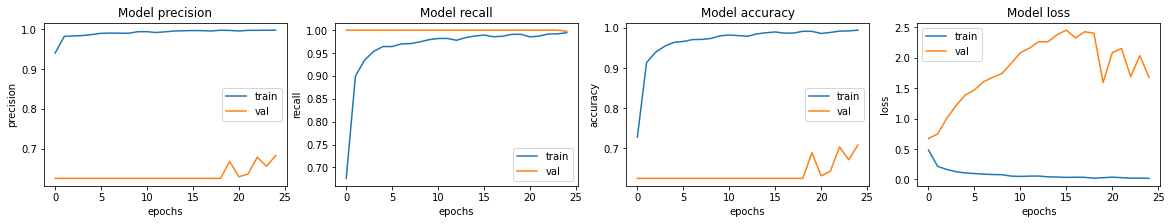

In [87]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [92]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
save_dir = target_dir

checkpoint_cb = ModelCheckpoint(save_dir + "/best_model_tuning.h5",
                                save_best_only=True)

early_stopping_cb = EarlyStopping(patience=25,
                                  restore_best_weights=True)

In [93]:

EPOCH = 100

In [97]:
 from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
 def exponential_decay(lr0, s):
     def exponential_decay_fn(epoch):
         return lr0 * 0.1 **(epoch / s)
     return exponential_decay_fn

 exponential_decay_fn = exponential_decay(0.01, 20)

 lr_scheduler = LearningRateScheduler(exponential_decay_fn)

In [98]:
history = model.fit(x_train, y_train,
              steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
              epochs=EPOCH,
              validation_data=(x_val, y_val),
              validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
              class_weight=class_weight,
              callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
              )

Epoch 1/100
40/40 [==============================] - 13s 326ms/step - loss: 0.2778 - accuracy: 0.9051 - precision: 0.9630 - recall: 0.9071 - val_loss: 2344.7136 - val_accuracy: 0.3766 - val_precision: 1.0000 - val_recall: 0.0026 - lr: 0.0100
Epoch 2/100
40/40 [==============================] - 14s 343ms/step - loss: 0.1642 - accuracy: 0.9369 - precision: 0.9807 - recall: 0.9334 - val_loss: 64.9960 - val_accuracy: 0.3750 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0089
Epoch 3/100
40/40 [==============================] - 14s 347ms/step - loss: 0.1225 - accuracy: 0.9526 - precision: 0.9848 - recall: 0.9510 - val_loss: 3.2339 - val_accuracy: 0.5240 - val_precision: 0.9794 - val_recall: 0.2436 - lr: 0.0079
Epoch 4/100
40/40 [==============================] - 13s 313ms/step - loss: 0.1045 - accuracy: 0.9622 - precision: 0.9907 - recall: 0.9582 - val_loss: 5.1703 - val_accuracy: 0.4551 - val_precision: 0.9808 - val_recall: 0.1308 - lr: 0.0071
Epoch 5/100
40/40 [=============

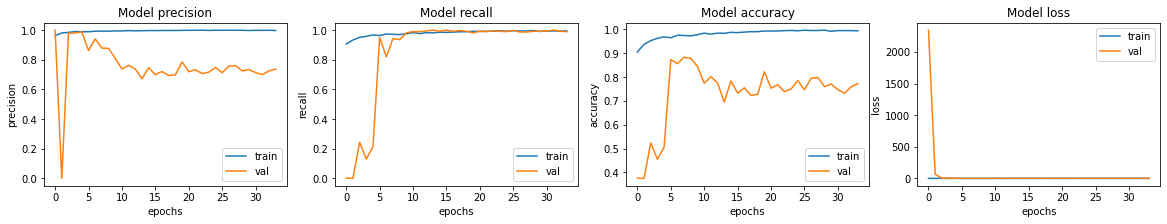

In [99]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])